<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
Построить модель с предельно большим значением *F1*-меры. Необходимо довести метрику до 0.59.

**План исследования данных оттока клиентов «Бета-Банка»:**

1) Загрузить данные из таблицы 'Churn.csv', изучить общую информацию и подготовить данные. Разделить исходные данные на обучающую, валидационную и тестовую выборки

2) Исследовать баланс классов, обучить модель без учёта дисбаланса.

3) Улучшить качество модели, учитывая дисбаланс классов. Обучить разные модели и найти лучшую.

4) Провести финальное тестирование.

6) Написать промежуточные и общий вывод по результатам исследования.


**Описание данных:**

- Признаки:
 - RowNumber — индекс строки в данных
 - CustomerId — уникальный идентификатор клиента
 - Surname — фамилия
 - CreditScore — кредитный рейтинг
 - Geography — страна проживания
 - Gender — пол
 - Age — возраст
 - Tenure — сколько лет человек является клиентом банка
 - Balance — баланс на счёте
 - NumOfProducts — количество продуктов банка, используемых клиентом
 - HasCrCard — наличие кредитной карты
 - IsActiveMember — активность клиента
 - EstimatedSalary — предполагаемая зарплата
- Целевой признак:
 - Exited — факт ухода клиента

## Подготовка данных

**1.1. Подгрузим бибилотеки и данные и изучим общую информацию.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
try:
    data = pd.read_csv('/datasets/Churn.csv', sep=',')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv', sep=',')

In [3]:
data.info()
display(data.describe())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [4]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

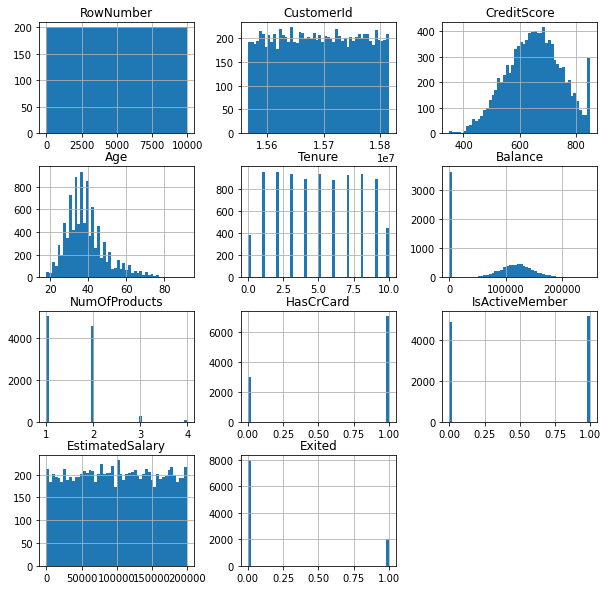

In [5]:
data.hist(figsize=(10, 10), bins=50);

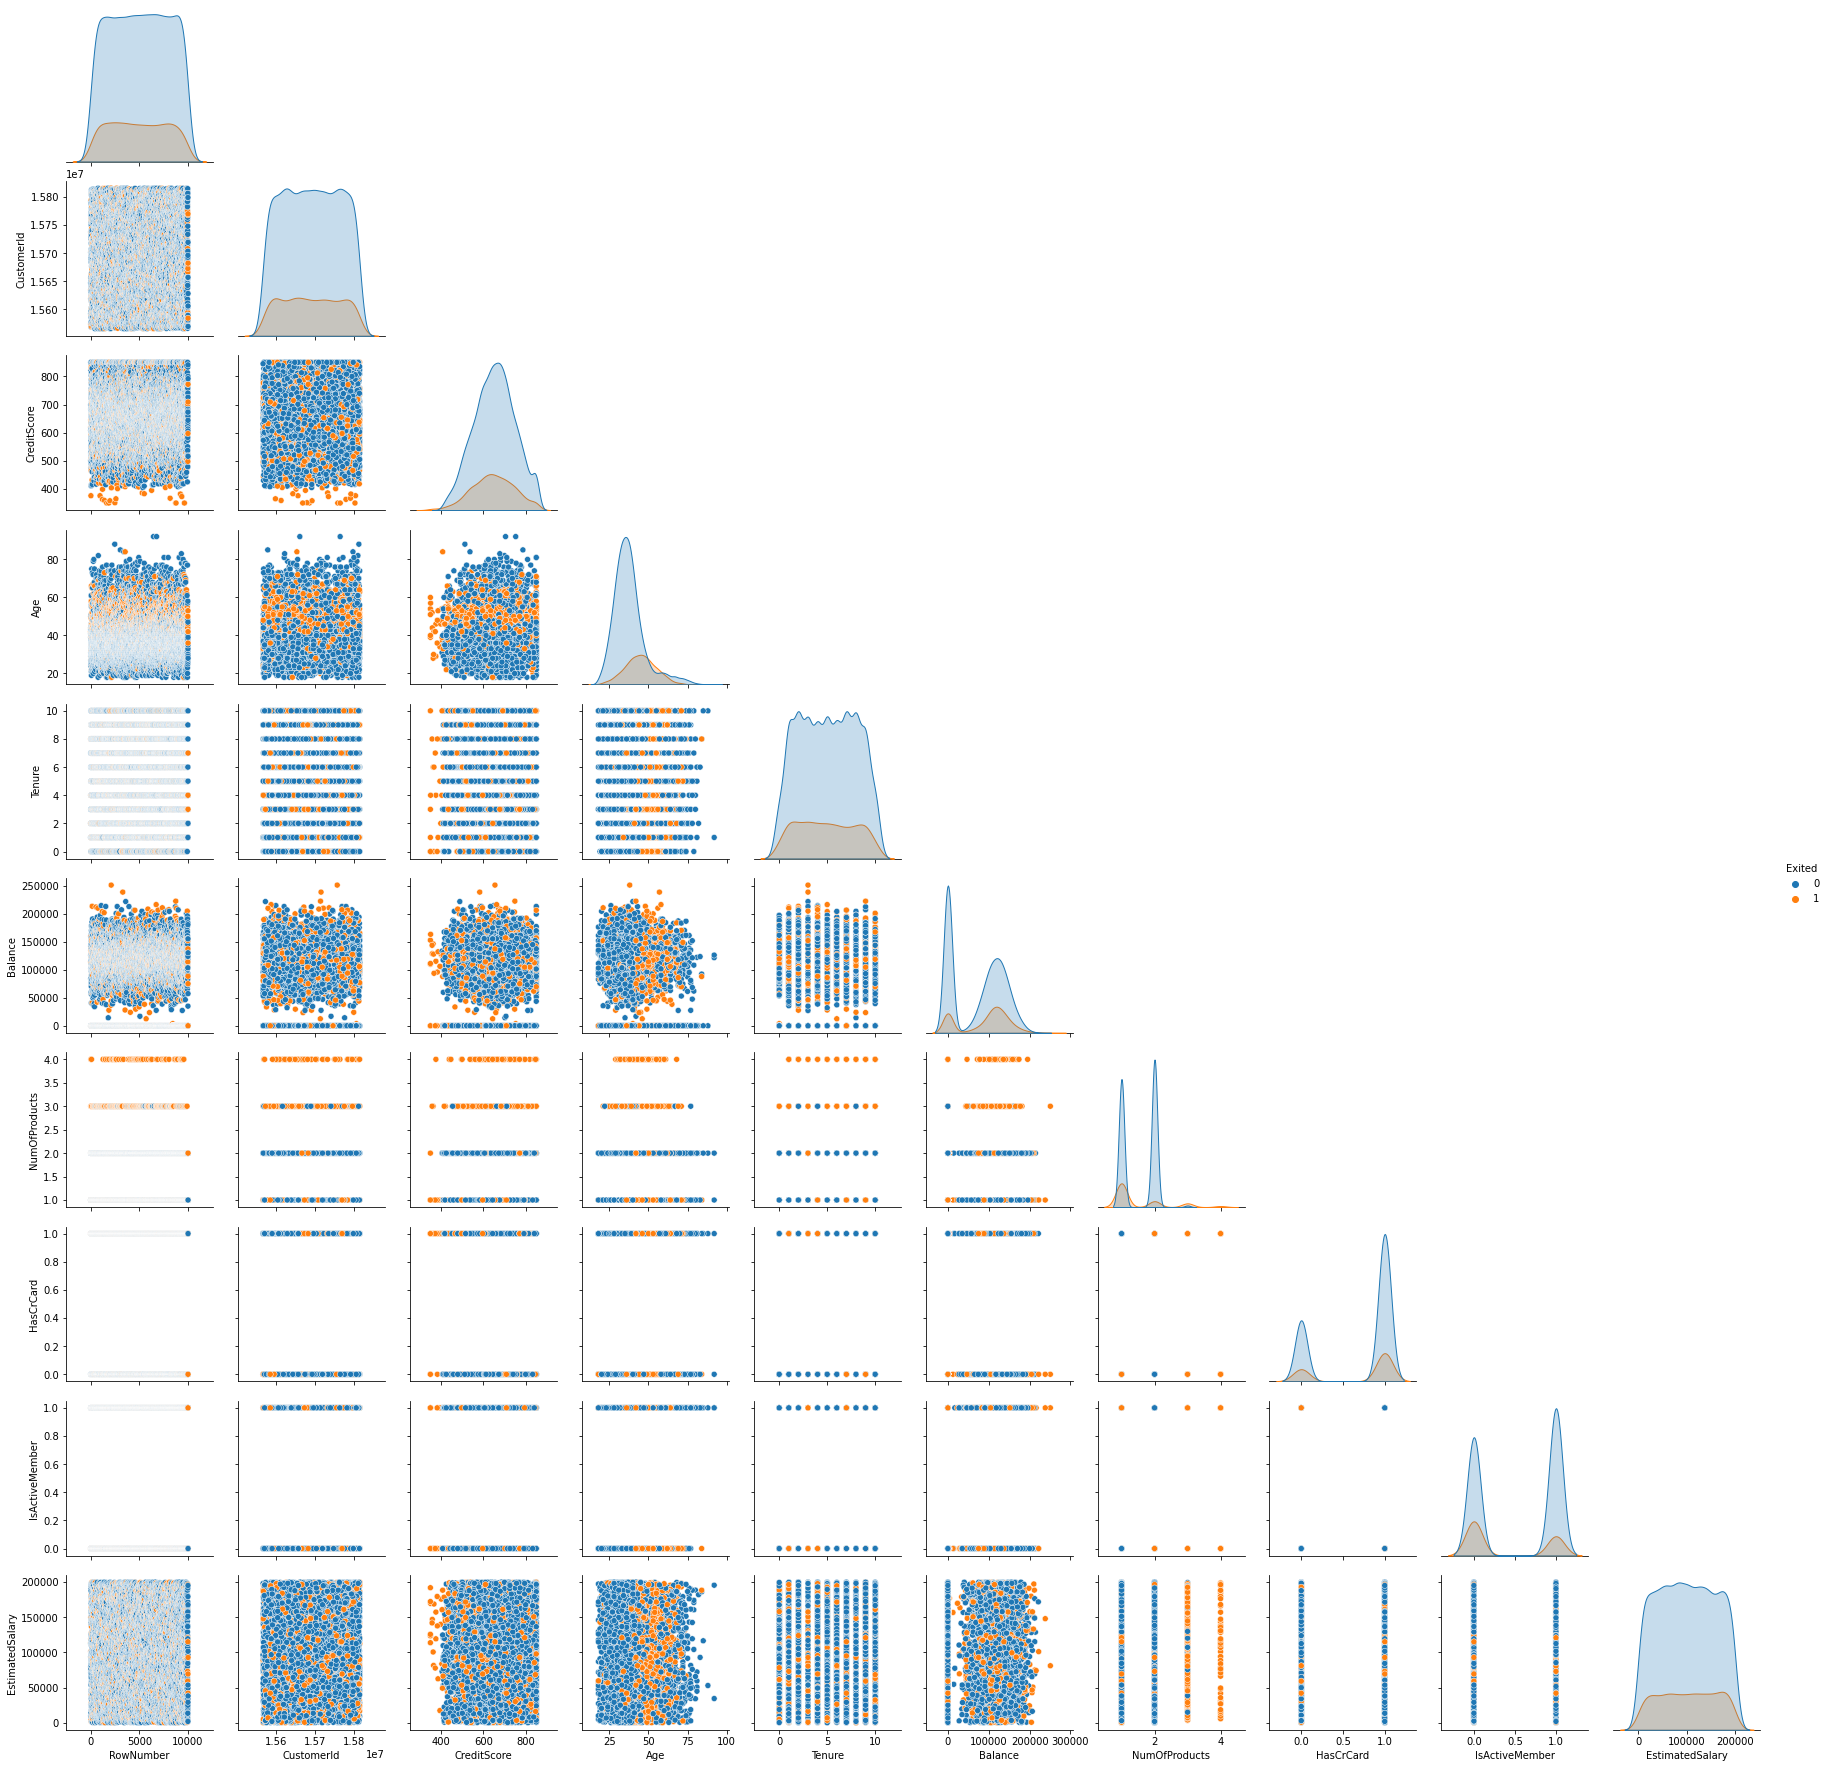

In [6]:
sns.pairplot(data, hue='Exited', corner=True);

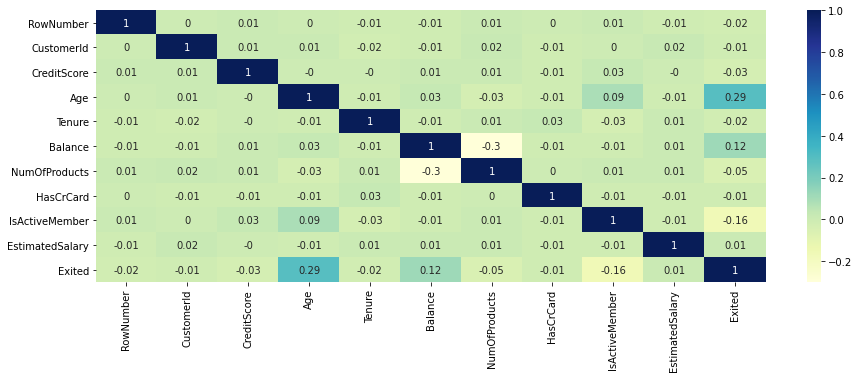

In [7]:
plt.figure(figsize=(15, 5))
sns.heatmap(data.corr().round(2), cmap="YlGnBu", annot=True)
plt.show()

**Общая информация**
- В представленном датасете 10000 объектов, 13 признаков и 1 целевой признак 'Exited — факт ухода клиента'.
- Очевидно, что столбцы 'RowNumber', 'CustomerId', 'Surname' положительно никак не повлияют на обучение моделей, поэтому далее исключим данные столбцы из датасета.
- Категориальные признаки 'Geography' и 'Gender' можно преобразовать в численные техникой прямого кодирования (OHE).
- Признаки 'CreditScore', 'Age', 'Balance', 'EstimatedSalary' можно будет масштабировать.
- В столбце 'Tenure' есть 909 пропущенных значений, заполним их позже.
- Заметен перекос в данных в факте ухода клиентов: нулей значительно больше, чем единиц.
- Значительной взаимной корреляции между признаками в датасете не отмечается.

**1.2. Выполним предобработку данных.**

**Для удобства приведем названия столбцов к нижнему регистру**

In [8]:
data.columns = data.columns.str.lower()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Заполним пропуски в стобце 'tenure' медианным значением**

In [9]:
print(data.groupby('tenure').agg({'tenure': ['count']})['tenure'])
# print(data[data['tenure'].isnull() == True].head(40))

        count
tenure       
0.0       382
1.0       952
2.0       950
3.0       928
4.0       885
5.0       927
6.0       881
7.0       925
8.0       933
9.0       882
10.0      446


In [10]:
data['tenure'].fillna(data['tenure'].median(), inplace=True)

data.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [11]:
data.isna().sum()
print(data.groupby('tenure').agg({'tenure': ['count']})['tenure'])

        count
tenure       
0.0       382
1.0       952
2.0       950
3.0       928
4.0       885
5.0      1836
6.0       881
7.0       925
8.0       933
9.0       882
10.0      446


In [12]:
# np.random.seed(42)
# data['tenure'] = data['tenure'].mask(data['tenure'].isna(), np.random.randint(0 , 11, size=len(data))).astype('int')
# print(data.groupby('tenure').agg({'tenure': ['count']})['tenure'])

In [13]:
data.isna().sum()

rownumber          0
customerid         0
surname            0
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

**Преобразуем категориальные признаки 'Geography' и 'Gender' в численные техникой прямого кодирования (OHE)**

In [14]:
print(data['gender'].unique())
print(data['geography'].unique())

['Female' 'Male']
['France' 'Spain' 'Germany']


In [15]:
data = pd.get_dummies(data=data, columns=['gender', 'geography'], drop_first=True)

In [16]:
data.head(5)

,rownumber,customerid,surname,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,gender_Male,geography_Germany,geography_Spain
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


In [17]:
data.columns = data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rownumber          10000 non-null  int64  
 1   customerid         10000 non-null  int64  
 2   surname            10000 non-null  object 
 3   creditscore        10000 non-null  int64  
 4   age                10000 non-null  int64  
 5   tenure             10000 non-null  float64
 6   balance            10000 non-null  float64
 7   numofproducts      10000 non-null  int64  
 8   hascrcard          10000 non-null  int64  
 9   isactivemember     10000 non-null  int64  
 10  estimatedsalary    10000 non-null  float64
 11  exited             10000 non-null  int64  
 12  gender_male        10000 non-null  uint8  
 13  geography_germany  10000 non-null  uint8  
 14  geography_spain    10000 non-null  uint8  
dtypes: float64(3), int64(8), object(1), uint8(3)
memory usage: 966.9+ KB


**Разделим исходные данные на обучающую, валидационную и тестовую выборки в соотношении 60/20/20 % и исключим столбцы 'RowNumber', 'CustomerId', 'Surname'.**

In [18]:
features = data.drop(['rownumber', 'customerid', 'surname', 'exited'], axis=1)
target = data['exited']
display(features)
display(target)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,gender_male,geography_germany,geography_spain
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,1,0,0
9996,516,35,10.0,57369.61,1,1,1,101699.77,1,0,0
9997,709,36,7.0,0.00,1,0,1,42085.58,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0


0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: exited, Length: 10000, dtype: int64

In [19]:
# разделяем на обучающую и тестовую выборки (60/40)
features_train, features_test, target_train, target_test  = train_test_split(features, 
                                                                             target, 
                                                                             test_size=0.4,
                                                                             stratify=target,
                                                                             random_state=12345)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 11)
(6000,)
(4000, 11)
(4000,)


In [20]:
# разделяем тестовую выборку на валидационную и тестовую (50/50)
features_valid, features_test, target_valid, target_test  = train_test_split(features_test, 
                                                                             target_test, 
                                                                             test_size=0.5,
                                                                             stratify=target_test,
                                                                             random_state=12345)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(2000, 11)
(2000,)
(2000, 11)
(2000,)


**Выборка разделена в нужной пропорции**

**Выполним масштабирование значений признаков 'CreditScore', 'Age', 'Balance', 'EstimatedSalary'.**

In [21]:
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_363/2864548151.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.fit_transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [22]:
display(features_train.head())
display(len(features_train))
display(len(features_valid))
display(len(features_test))
features_train.info()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,gender_male,geography_germany,geography_spain
2837,-1.040434,0.953312,6.0,0.774657,1,0,1,-0.119110,0,1,0
9925,0.454006,-0.095244,5.0,1.910540,1,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,8.0,0.481608,2,0,1,1.422836,1,0,0
660,-0.184996,0.190726,5.0,0.088439,1,1,1,-1.160427,0,1,0
3610,-0.720933,1.620574,1.0,0.879129,1,1,0,0.113236,0,0,0


6000

2000

2000

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 2837 to 700
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   creditscore        6000 non-null   float64
 1   age                6000 non-null   float64
 2   tenure             6000 non-null   float64
 3   balance            6000 non-null   float64
 4   numofproducts      6000 non-null   int64  
 5   hascrcard          6000 non-null   int64  
 6   isactivemember     6000 non-null   int64  
 7   estimatedsalary    6000 non-null   float64
 8   gender_male        6000 non-null   uint8  
 9   geography_germany  6000 non-null   uint8  
 10  geography_spain    6000 non-null   uint8  
dtypes: float64(5), int64(3), uint8(3)
memory usage: 439.5 KB


**Масштабирование выполнено корректно**

## Исследование задачи

**2.1. Изучим баланс классов.**

0    7963
1    2037
Name: exited, dtype: int64


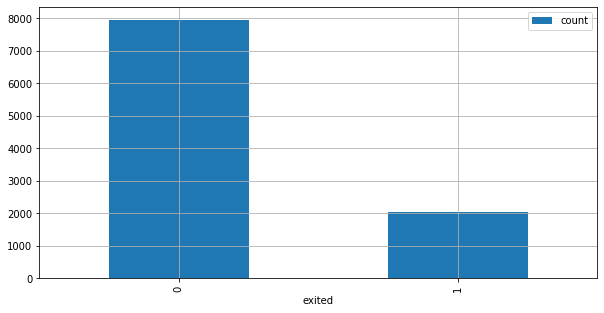

In [23]:
print(data['exited'].value_counts())
data.groupby('exited').agg({'exited': ['count']})['exited'] \
.plot(y='count', kind='bar', figsize=(10, 5), grid=True);

**Видим явный дисбаланс классов в целевом признаке. Чуть больше 20% клиентов ушли из банка. Значений '1' меньше почти в 4 раза, чем '0'.**

**Для начала обучим модели без учета дисбаланса**

**2.2. Дерево решений.**

In [24]:
%%time

best_model_tree = None
best_depth_tree = 0
best_f1_tree = 0
for depth in range(1, 11):
    for leaf in range(1,6):
        model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf)
        model_tree.fit(features_train, target_train)
        predictions_valid_tree = model_tree.predict(features_valid)
        result_tree = f1_score(target_valid, predictions_valid_tree)
        if result_tree > best_f1_tree:
            best_model_tree = model_tree
            best_depth_tree = depth
            best_leaf_tree = leaf
            best_f1_tree = result_tree
        
print("Глубина 'Max_depth' лучшей модели:", best_depth_tree)
print("Количество элементов в узле 'min_samples_leaf' лучшей модели:", best_leaf_tree)
print("'F1-мера' лучшей модели:", best_f1_tree)

Глубина 'Max_depth' лучшей модели: 7
Количество элементов в узле 'min_samples_leaf' лучшей модели: 2
'F1-мера' лучшей модели: 0.5953757225433526
CPU times: user 806 ms, sys: 7.89 ms, total: 813 ms
Wall time: 822 ms


***Обучим модель Дерева решений с лучшими гиперпараметрами.***

In [25]:
model_tree = DecisionTreeClassifier(random_state=12345,
                                    max_depth=7,
                                    min_samples_leaf=2)
model_tree.fit(features_train, target_train)
predictions_valid_tree = model_tree.predict(features_valid)
result_tree = f1_score(target_valid, predictions_valid_tree)
print("'F1-мера':", result_tree)

'F1-мера': 0.5953757225433526


**2.3. Случайный лес**

In [26]:
%%time

best_model_forest = None
best_est_forest = 0
best_depth_forest = 0
best_f1_forest = 0
for est in range(10, 101, 10):
    for depth in range(1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train)
        predictions_valid_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predictions_valid_forest)
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_est_forest = est
            best_depth_forest = depth
            best_f1_forest = result_forest

print("Количество деревьев 'Estimators' лучшей модели:", best_est_forest)
print("Глубина 'Max_depth' лучшей модели:", best_depth_forest)
print("'F1-мера' лучшей модели:", best_f1_forest)

Количество деревьев 'Estimators' лучшей модели: 10
Глубина 'Max_depth' лучшей модели: 9
'F1-мера' лучшей модели: 0.5941807044410413
CPU times: user 22.4 s, sys: 135 ms, total: 22.6 s
Wall time: 22.6 s


***Обучим модель Случайного леса с лучшими гиперпараметрами.***

In [27]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=10, 
                                      max_depth=9)
model_forest.fit(features_train, target_train)
predictions_valid_forest = model_forest.predict(features_valid)
result_forest = f1_score(target_valid, predictions_valid_forest)
print("'F1-мера':", result_forest)

'F1-мера': 0.5941807044410413


**2.4. Логистическая регрессия.**

In [28]:
%%time

model_logistic = LogisticRegression(random_state=12345) 
model_logistic.fit(features_train, target_train) 
predictions_valid_logistic = model_logistic.predict(features_valid)
result_logistic = f1_score(target_valid, predictions_valid_logistic)

print("'F1-мера':", result_logistic)

'F1-мера': 0.30458715596330277
CPU times: user 133 ms, sys: 279 ms, total: 412 ms
Wall time: 351 ms


**Исследование моделей**
- Модель "Решающее дерево" (DecisionTreeClassifier): глубина 'Max_depth' лучшей модели: 7; Количество элементов в узле 'min_samples_leaf' лучшей модели: 2; 'F1-мера' лучшей модели: 0.5953757225433526.
- Модель "Случайный лес" (RandomForestClassifier): количество деревьев 'Estimators' лучшей модели: 10; глубина 'Max_depth' лучшей модели: 9; 'F1-мера' лучшей модели: 0.5941807044410413.
- Модель "Логическая регрессия" (LogisticRegression): 'F1-мера': 0.30458715596330277.

**Наибольшую 'F1-меру' показали модели "Решающее дерево" и "Случайный лес", которая составила в среднем 0.59.**

**2.5. Матрица ошибок.**

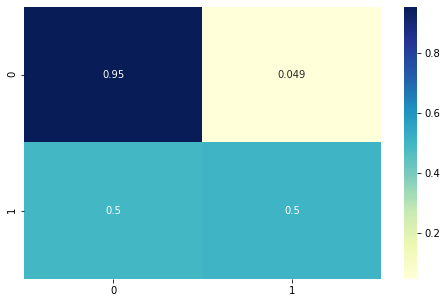

In [29]:
#Дерево решений
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_matrix(target_valid, predictions_valid_tree, normalize='true'), cmap="YlGnBu", annot=True)
plt.show()

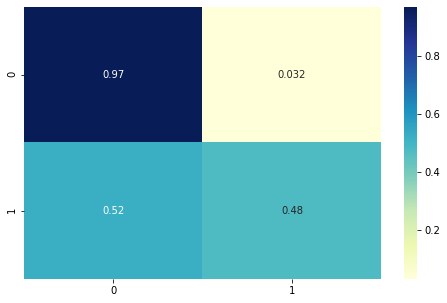

In [30]:
# Случайный лес
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_matrix(target_valid, predictions_valid_forest, normalize='true'), cmap="YlGnBu", annot=True)
plt.show()

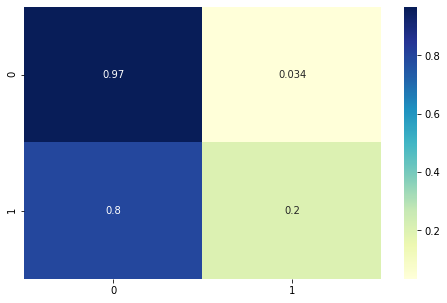

In [31]:
# Логистическая регрессия
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_matrix(target_valid, predictions_valid_logistic, normalize='true'), cmap="YlGnBu", annot=True)
plt.show()

**Отмечается сильный дисбаланс классов. Для Дерева реший и Случайного леса в 95-97% случаев верно определяется, что клиент остался в банке (0), а факт ухода клиента (1) определяется правильно в 48-50 % случаев.**

## Борьба с дисбалансом

**3.1. Взвешивание классов.**

**3.1.1. Дерево решений.**

In [32]:
%%time

best_model_tree = None
best_depth_tree = 0
best_leaf_tree = 0
best_f1_tree = 0
for depth in range(1, 11):
    for leaf in range(1,6):
        model_tree = DecisionTreeClassifier(random_state=12345, 
                                            max_depth=depth, 
                                            min_samples_leaf=leaf, 
                                            class_weight='balanced')
        model_tree.fit(features_train, target_train)
        predictions_valid_tree = model_tree.predict(features_valid)
        result_tree = f1_score(target_valid, predictions_valid_tree)
        if result_tree > best_f1_tree:
            best_model_tree = model_tree
            best_depth_tree = depth
            best_leaf_tree = leaf
            best_f1_tree = result_tree
        
print("Глубина 'Max_depth' лучшей модели:", best_depth_tree)
print("Количество элементов в узле 'min_samples_leaf' лучшей модели:", best_leaf_tree)
print("'F1-мера' лучшей модели:", best_f1_tree)


Глубина 'Max_depth' лучшей модели: 6
Количество элементов в узле 'min_samples_leaf' лучшей модели: 3
'F1-мера' лучшей модели: 0.5769585253456221
CPU times: user 1.26 s, sys: 7.94 ms, total: 1.27 s
Wall time: 1.28 s


***Обучим модель Дерева решений с лучшими гиперпараметрами.***

In [33]:
model_tree = DecisionTreeClassifier(random_state=12345,
                                    max_depth=6,
                                    min_samples_leaf=3,
                                    class_weight='balanced')
model_tree.fit(features_train, target_train)
predictions_valid_tree = model_tree.predict(features_valid)
result_tree = f1_score(target_valid, predictions_valid_tree)

probabilities_valid_tree = model_tree.predict_proba(features_valid)
probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)
print("'F1-мера_tree':", result_tree)
print("'AUC-ROC_tree':", auc_roc_tree)


'F1-мера_tree': 0.5769585253456221
'AUC-ROC_tree': 0.8269895740959702


**3.1.2. Случайный лес.**

In [34]:
%%time

best_model_forest = None
best_est_forest = 0
best_depth_forest = 0
best_f1_forest = 0
for est in range(10, 101, 10):
    for depth in range(1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model_forest.fit(features_train, target_train)
        predictions_valid_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predictions_valid_forest)
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_est_forest = est
            best_depth_forest = depth
            best_f1_forest = result_forest

print("Количество деревьев 'Estimators' лучшей модели:", best_est_forest)
print("Глубина 'Max_depth' лучшей модели:", best_depth_forest)
print("'F1-мера' лучшей модели:", best_f1_forest)

Количество деревьев 'Estimators' лучшей модели: 100
Глубина 'Max_depth' лучшей модели: 9
'F1-мера' лучшей модели: 0.6482122260668973
CPU times: user 22.6 s, sys: 87.8 ms, total: 22.7 s
Wall time: 22.7 s


***Обучим модель Случайного леса с лучшими гиперпараметрами.***

In [35]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=100, 
                                      max_depth=9,
                                      class_weight='balanced')
model_forest.fit(features_train, target_train)
predictions_valid_forest = model_forest.predict(features_valid)
result_forest = f1_score(target_valid, predictions_valid_forest)

probabilities_valid_forest = model_forest.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
auc_roc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)
print("'F1-мера_forest':", result_forest)
print("'AUC-ROC_forest':", auc_roc_forest)

'F1-мера_forest': 0.6482122260668973
'AUC-ROC_forest': 0.8683752709626563


**3.1.3. Логистическая регрессия**

In [36]:
%%time

model_logistic = LogisticRegression(random_state=12345, class_weight='balanced') 
model_logistic.fit(features_train, target_train) 
predictions_valid_logistic = model_logistic.predict(features_valid)
result_logistic = f1_score(target_valid, predictions_valid_logistic)

probabilities_valid_logistic = model_logistic.predict_proba(features_valid)
probabilities_one_valid_logistic = probabilities_valid_logistic[:, 1]
auc_roc_logistic = roc_auc_score(target_valid, probabilities_one_valid_logistic)
print("'F1-мера_logistic':", result_logistic)
print("'AUC-ROC_logistic':", auc_roc_logistic)

'F1-мера_logistic': 0.5285338015803336
'AUC-ROC_logistic': 0.7937035052714554
CPU times: user 79.7 ms, sys: 172 ms, total: 252 ms
Wall time: 186 ms


**3.2. Увеличение выборки.**

**Увеличим положительный класс целевого признака в 4 раза, так как он меньше отрицаельного в 4 раза.** 

In [37]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
        
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)



print(features_upsampled.shape)
print(target_upsampled.shape)

(9666, 11)
(9666,)


**3.2.1. Дерево решений.**

In [38]:
%%time

best_model_tree = None
best_depth_tree = 0
best_leaf_tree = 0
best_f1_tree = 0
for depth in range(1, 11):
    for leaf in range(1,6):
        model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf)
        model_tree.fit(features_upsampled, target_upsampled)
        predictions_valid_tree = model_tree.predict(features_valid)
        result_tree = f1_score(target_valid, predictions_valid_tree)
        if result_tree > best_f1_tree:
            best_model_tree = model_tree
            best_depth_tree = depth
            best_leaf_tree = leaf
            best_f1_tree = result_tree
        
print("Глубина 'Max_depth' лучшей модели:", best_depth_tree)
print("Количество элементов в узле 'min_samples_leaf' лучшей модели:", best_leaf_tree)
print("'F1-мера' лучшей модели:", best_f1_tree)

Глубина 'Max_depth' лучшей модели: 6
Количество элементов в узле 'min_samples_leaf' лучшей модели: 3
'F1-мера' лучшей модели: 0.5780240073868882
CPU times: user 1.09 s, sys: 7.82 ms, total: 1.1 s
Wall time: 1.11 s


***Обучим модель Дерева решений с лучшими гиперпараметрами.***

In [39]:
model_tree = DecisionTreeClassifier(random_state=12345,
                                    max_depth=6,
                                    min_samples_leaf=3,
                                    )
model_tree.fit(features_upsampled, target_upsampled)
predictions_valid_tree = model_tree.predict(features_valid)
result_tree = f1_score(target_valid, predictions_valid_tree)

probabilities_valid_tree = model_tree.predict_proba(features_valid)
probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)
print("'F1-мера_tree':", result_tree)
print("'AUC-ROC_tree':", auc_roc_tree)


'F1-мера_tree': 0.5780240073868882
'AUC-ROC_tree': 0.8265107707655928


**3.2.2. Случайный лес.**

In [40]:
%%time

best_model_forest = None
best_est_forest = 0
best_depth_forest = 0
best_f1_forest = 0
for est in range(10, 101, 10):
    for depth in range(1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_upsampled, target_upsampled)
        predictions_valid_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predictions_valid_forest)
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_est_forest = est
            best_depth_forest = depth
            best_f1_forest = result_forest

print("Количество деревьев 'Estimators' лучшей модели:", best_est_forest)
print("Глубина 'Max_depth' лучшей модели:", best_depth_forest)
print("'F1-мера' лучшей модели:", best_f1_forest)

Количество деревьев 'Estimators' лучшей модели: 50
Глубина 'Max_depth' лучшей модели: 9
'F1-мера' лучшей модели: 0.6531483457844184
CPU times: user 31.1 s, sys: 95.7 ms, total: 31.2 s
Wall time: 31.4 s


***Обучим модель Случайного леса с лучшими гиперпараметрами.***

In [41]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=50, 
                                      max_depth=9)
model_forest.fit(features_upsampled, target_upsampled)
predictions_valid_forest = model_forest.predict(features_valid)
result_forest = f1_score(target_valid, predictions_valid_forest)

probabilities_valid_forest = model_forest.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
auc_roc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)
print("'F1-мера_forest':", result_forest)
print("'AUC-ROC_forest':", auc_roc_forest)

'F1-мера_forest': 0.6531483457844184
'AUC-ROC_forest': 0.8719578283574736


**3.2.3. Логистическая регрессия**

In [42]:
%%time

model_logistic = LogisticRegression(random_state=12345, solver='liblinear') 
model_logistic.fit(features_upsampled, target_upsampled) 
predictions_valid_logistic = model_logistic.predict(features_valid)
result_logistic = f1_score(target_valid, predictions_valid_logistic)

probabilities_valid_logistic = model_logistic.predict_proba(features_valid)
probabilities_one_valid_logistic = probabilities_valid_logistic[:, 1]
auc_roc_logistic = roc_auc_score(target_valid, probabilities_one_valid_logistic)
print("'F1-мера_logistic':", result_logistic)
print("'AUC-ROC_logistic':", auc_roc_logistic)

'F1-мера_logistic': 0.5242214532871973
'AUC-ROC_logistic': 0.7938051162676125
CPU times: user 52.6 ms, sys: 35.9 ms, total: 88.5 ms
Wall time: 44.3 ms


**3.3. Уменьшение выборки.**

**Уменьшим отрицательный класс целевого признака в 4 раза, так как он больше положительного в 4 раза.** 

In [43]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2416, 11)
(2416,)


**3.3.1. Дерево решений.**

In [44]:
%%time

best_model_tree = None
best_depth_tree = 0
best_leaf_tree = 0
best_f1_tree = 0
for depth in range(1, 11):
    for leaf in range(1,6):
        model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf)
        model_tree.fit(features_downsampled, target_downsampled)
        predictions_valid_tree = model_tree.predict(features_valid)
        result_tree = f1_score(target_valid, predictions_valid_tree)
        if result_tree > best_f1_tree:
            best_model_tree = model_tree
            best_depth_tree = depth
            best_leaf_tree = leaf
            best_f1_tree = result_tree
        
print("Глубина 'Max_depth' лучшей модели:", best_depth_tree)
print("Количество элементов в узле 'min_samples_leaf' лучшей модели:", best_leaf_tree)
print("'F1-мера' лучшей модели:", best_f1_tree)

Глубина 'Max_depth' лучшей модели: 6
Количество элементов в узле 'min_samples_leaf' лучшей модели: 3
'F1-мера' лучшей модели: 0.5958254269449715
CPU times: user 458 ms, sys: 0 ns, total: 458 ms
Wall time: 469 ms


***Обучим модель Дерева решений с лучшими гиперпараметрами.***

In [45]:
model_tree = DecisionTreeClassifier(random_state=12345,
                                    max_depth=6,
                                    min_samples_leaf=3,
                                    )
model_tree.fit(features_downsampled, target_downsampled)
predictions_valid_tree = model_tree.predict(features_valid)
result_tree = f1_score(target_valid, predictions_valid_tree)

probabilities_valid_tree = model_tree.predict_proba(features_valid)
probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)
print("'F1-мера_tree':", result_tree)
print("'AUC-ROC_tree':", auc_roc_tree)

'F1-мера_tree': 0.5958254269449715
'AUC-ROC_tree': 0.8508435252241601


**3.3.2. Случайный лес.**

In [46]:
%%time

best_model_forest = None
best_est_forest = 0
best_depth_forest = 0
best_f1_forest = 0
for est in range(10, 101, 10):
    for depth in range(1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_downsampled, target_downsampled)
        predictions_valid_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predictions_valid_forest)
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_est_forest = est
            best_depth_forest = depth
            best_f1_forest = result_forest

print("Количество деревьев 'Estimators' лучшей модели:", best_est_forest)
print("Глубина 'Max_depth' лучшей модели:", best_depth_forest)
print("'F1-мера' лучшей модели:", best_f1_forest)

Количество деревьев 'Estimators' лучшей модели: 70
Глубина 'Max_depth' лучшей модели: 6
'F1-мера' лучшей модели: 0.6332046332046332
CPU times: user 14.9 s, sys: 152 ms, total: 15 s
Wall time: 15 s


***Обучим модель Случайного леса с лучшими гиперпараметрами.***

In [47]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=70, 
                                      max_depth=6)
model_forest.fit(features_downsampled, target_downsampled)
predictions_valid_forest = model_forest.predict(features_valid)
result_forest = f1_score(target_valid, predictions_valid_forest)

probabilities_valid_forest = model_forest.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
auc_roc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)
print("'F1-мера_forest':", result_forest)
print("'AUC-ROC_forest':", auc_roc_forest)

'F1-мера_forest': 0.6332046332046332
'AUC-ROC_forest': 0.8677024830032516


**3.3.3. Логистическая регрессия.**

In [48]:
%%time

model_logistic = LogisticRegression(random_state=12345, solver='liblinear') 
model_logistic.fit(features_downsampled, target_downsampled) 
predictions_valid_logistic = model_logistic.predict(features_valid)
result_logistic = f1_score(target_valid, predictions_valid_logistic)

probabilities_valid_logistic = model_logistic.predict_proba(features_valid)
probabilities_one_valid_logistic = probabilities_valid_logistic[:, 1]
auc_roc_logistic = roc_auc_score(target_valid, probabilities_one_valid_logistic)
print("'F1-мера_logistic':", result_logistic)
print("'AUC-ROC_logistic':", auc_roc_logistic)

'F1-мера_logistic': 0.5275862068965517
'AUC-ROC_logistic': 0.792638129372352
CPU times: user 18.9 ms, sys: 39.7 ms, total: 58.7 ms
Wall time: 23 ms


**Создадим сводную таблицу с результатами определения F1-меры**

In [49]:
model_type = ['Tree', 'Forest', 'Logistic']
F1_raw = [0.60, 0.59, 0.31]
F1_weight = [0.58, 0.65, 0.53]
F1_upsampled = [0.59, 0.65, 0.52]
F1_downsampled = [0.60, 0.63, 0.53]

AUC_ROC_raw = ['-', '-', '-']
AUC_ROC_weight = [0.83, 0.87, 0.79]
AUC_ROC_upsampled = [0.83, 0.87, 0.79]
AUC_ROC_downsampled = [0.85, 0.87, 0.79]

F1_result = pd.DataFrame({'Model Type': model_type,
                           'Raw F1': F1_raw,
                           'Raw AUC-ROC': AUC_ROC_raw,
                           'Weight F1': F1_weight,
                           'Weight AUC-ROC': AUC_ROC_weight,
                           'Upsampled F1': F1_upsampled,
                           'Upsampled AUC-ROC': AUC_ROC_upsampled,
                           'Downsampled F1': F1_downsampled,
                           'Downsampled AUC-ROC': AUC_ROC_downsampled
                         })

F1_result

,Model Type,Raw F1,Raw AUC-ROC,Weight F1,Weight AUC-ROC,Upsampled F1,Upsampled AUC-ROC,Downsampled F1,Downsampled AUC-ROC
0,Tree,0.60,-,0.58,0.83,0.59,0.83,0.60,0.85
1,Forest,0.59,-,0.65,0.87,0.65,0.87,0.63,0.87
2,Logistic,0.31,-,0.53,0.79,0.52,0.79,0.53,0.79


**Вывод:**
- Значения AUC-ROC модели случайного леса наибольшие, для логистической регрессии - наименьшие.
- Наибольшие F1-мера и AUC-ROC получены для моделей случайного леса при использовании взвешивания классов и увеличения выборки равны 0,65 и 0,87, соответственно.

## Тестирование модели

**Наилучшие метрики показали модели случайного леса. Протестируем на тестовой выборке модель случайного леса при использовании взвешивания классов.**

In [50]:
%%time

best_model_forest = None
best_est_forest = 0
best_depth_forest = 0
best_f1_forest = 0
for est in range(10, 101, 10):
    for depth in range(1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model_forest.fit(features_train, target_train)
        predictions_valid_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predictions_valid_forest)
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_est_forest = est
            best_depth_forest = depth
            best_f1_forest = result_forest

print("Количество деревьев 'Estimators' лучшей модели:", best_est_forest)
print("Глубина 'Max_depth' лучшей модели:", best_depth_forest)

Количество деревьев 'Estimators' лучшей модели: 100
Глубина 'Max_depth' лучшей модели: 9
CPU times: user 22.8 s, sys: 180 ms, total: 22.9 s
Wall time: 23 s


In [51]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=100, 
                                      max_depth=9,
                                      class_weight='balanced')
model_forest.fit(features_train, target_train)
predictions_test_forest = model_forest.predict(features_test)
result_forest = f1_score(target_test, predictions_test_forest)

probabilities_test_forest = model_forest.predict_proba(features_test)
probabilities_one_test_forest = probabilities_test_forest[:, 1]
auc_roc_forest = roc_auc_score(target_test, probabilities_one_test_forest)
print("'F1-мера_forest' на тестовой выборке:", result_forest)
print("'AUC-ROC_forest' на тестовой выборке:", auc_roc_forest)

'F1-мера_forest' на тестовой выборке: 0.6093189964157706
'AUC-ROC_forest' на тестовой выборке: 0.853944853944854


**F1-мера на тестовой выборке для модели случайного леса при использовании взвешивания классов получена равной 0,61, что больше необходимой, AUC-ROC равна 0,85.**

**Построем ROC-кривую и изобразим её на графике**

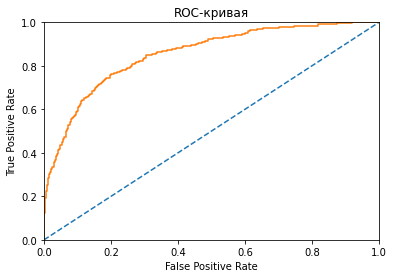

In [52]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_forest)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Общий вывод

**Общая информация и предобработка данных**

- В представленном датасете 10000 объектов, 13 признаков и 1 целевой признак 'Exited — факт ухода клиента'.
- Очевидно, что столбцы 'RowNumber', 'CustomerId', 'Surname' положительно никак не повлияют на обучение моделей, поэтому данные столбцы исключены из датасета.
- Категориальные признаки 'Geography' и 'Gender' преобразованы в численные техникой прямого кодирования (OHE).
- Признаки 'CreditScore', 'Age', 'Balance', 'EstimatedSalary' можно будет масштабировать.
- В столбце 'Tenure' есть 909 пропущенных значений, заполнены медианным значением.
- Заметен перекос в данных в факте ухода клиентов: нулей значительно больше, чем единиц.
- Значительной взаимной корреляции между признаками в датасете не отмечается.
- Для удобства названия столбцов приведены к нижнему регистру.
- Исходные данные поделены на обучающую, валидационную и тестовую выборки в соотношении 60/20/20 %.

**Выполнено исследование моделей без учета дисбаланса и получены следующие метрики:**

- Модель "Решающее дерево" (DecisionTreeClassifier): глубина 'Max_depth' лучшей модели: 7; Количество элементов в узле 'min_samples_leaf' лучшей модели: 2; 'F1-мера' лучшей модели: 0.5953757225433526.
- Модель "Случайный лес" (RandomForestClassifier): количество деревьев 'Estimators' лучшей модели: 10; глубина 'Max_depth' лучшей модели: 9; 'F1-мера' лучшей модели: 0.5941807044410413.
- Модель "Логическая регрессия" (LogisticRegression): 'F1-мера': 0.30458715596330277.
- Наибольшую 'F1-меру' показали модели "Решающее дерево" и "Случайный лес", которая составила в среднем 0.59.

**Исследование дисбаланса классов**
- Отмечен явный дисбаланс классов в целевом признаке. Чуть больше 20% клиентов ушли из банка. Значений '1' меньше почти в 4 раза, чем '0'. Для Дерева реший и Случайного леса в 95-97% случаев верно определяется, что клиент остался в банке (0), а факт ухода клиента (1) определяется правильно в 48-50 % случаев.

**Для борьбы с дисбалансом классов использовалось следующее:**
- Взвешивание классов.
- Увеличение выборки (увеличен положительный класс целевого признака в 4 раза, так как он меньше отрицаельного в 4 раза).
- Уменьшение выборки (уменьшен отрицательный класс целевого признака в 4 раза, так как он больше положительного в 4 раза).

***Создана сводная таблица с результатами определения F1-меры и AUC-ROC***
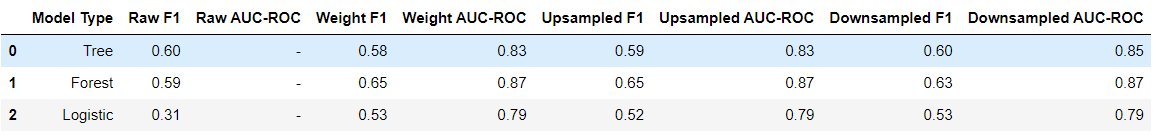

- Значения AUC-ROC модели случайного леса наибольшие, для логистической регрессии - наименьшие.
- Наибольшие F1-мера и AUC-ROC получены для моделей случайного леса при использовании взвешивания классов и увеличения выборки равны 0,65 и 0,87, соответственно.

**Выполнено тестирование модели случайного леса на тестовой выборке**

- F1-мера на тестовой выборке для модели случайного леса при использовании взвешивания классов получена равной 0,61, что больше необходимой, AUC-ROC равна 0,85.

***Для наглядности построена ROC-кривая***
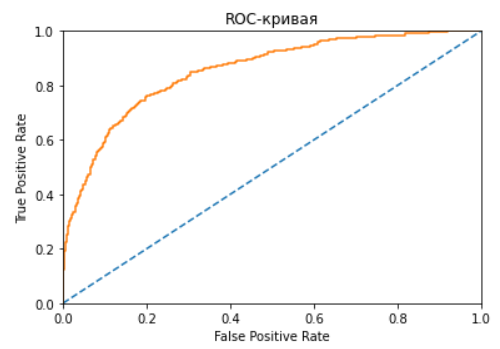